# Package and Data Importing

In [54]:
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from category_encoders import OneHotEncoder
import seaborn as sns
from xgboost import XGBClassifier

df = pd.read_csv('./churn_ds.csv')

# Data Cleaning and Train/Validate/Test Split

In [8]:
def fix_float(cell):
  try: 
    return float(cell)
  except: 
    print(cell)
    return np.NaN

### Feature / Target Split 
- By using this set of data our goal is to predict if a customer is likely to continue service with the provider. The **Target** will be if the customer has Churned - that means they have discontinued service. Churn is a term used in marketing to describe when a customer comes into the system and leaves rather quickly, yeild a low CLV. The Feature we will be using to predict this will be a combination of person charateristics: Age, Gender, Family. Service offers they currently have with the provider: Phone Service, Internet Service, Online Security, Streaming TV, etc. Also Subscription details: Contract, Billing, Payment Method, Monthly and Total Charges. 

In [64]:
X_train.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [14]:
# Cleaning Wrangle function 

def wrangle(X):
    
    X = X.copy()
    
    # fixing column to change to float
    X['TotalCharges'] = X['TotalCharges'].apply(fix_float)
                                                  
    # replacing Yes/No with True/False
    columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']                                              
    for col in columns:
        X[col] = X[col].apply(lambda cell: cell.lower() == 'yes')

    y = X['Churn']    
        
    X.drop(['customerID', 'Churn'], axis=1, inplace=True)
                                                  
    return X, y

X, y = wrangle(df)

In [10]:
print(X.shape)
print(y.shape)

(7043, 19)
(7043,)


In [11]:
# Train Val split 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.30, stratify=y, random_state=42)

In [12]:
# Val test split 
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.50, stratify=y_val, random_state=42)

In [13]:
# checking for CV sizes
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(4930, 19)
(4930,)
(1056, 19)
(1056,)
(1057, 19)
(1057,)


In [15]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5557,Female,0,False,False,5,True,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,False,Electronic check,80.20,384.25
2270,Female,1,False,False,3,True,No,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,True,Electronic check,86.85,220.95
6930,Female,0,True,False,3,True,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,True,Credit card (automatic),75.15,216.75
2257,Female,0,False,False,60,True,Yes,DSL,No,No,Yes,Yes,Yes,Yes,One year,False,Credit card (automatic),80.55,4847.05
898,Female,0,False,False,12,True,No,Fiber optic,Yes,No,No,Yes,Yes,Yes,Month-to-month,True,Bank transfer (automatic),98.90,1120.95


In [23]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4930 entries, 5557 to 5639
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            4930 non-null   object 
 1   SeniorCitizen     4930 non-null   int64  
 2   Partner           4930 non-null   bool   
 3   Dependents        4930 non-null   bool   
 4   tenure            4930 non-null   int64  
 5   PhoneService      4930 non-null   bool   
 6   MultipleLines     4930 non-null   object 
 7   InternetService   4930 non-null   object 
 8   OnlineSecurity    4930 non-null   object 
 9   OnlineBackup      4930 non-null   object 
 10  DeviceProtection  4930 non-null   object 
 11  TechSupport       4930 non-null   object 
 12  StreamingTV       4930 non-null   object 
 13  StreamingMovies   4930 non-null   object 
 14  Contract          4930 non-null   object 
 15  PaperlessBilling  4930 non-null   bool   
 16  PaymentMethod     4930 non-null   objec

# Baseline

In [31]:
# Baseline
y_train.value_counts(normalize=True)

False    0.734686
True     0.265314
Name: Churn, dtype: float64

### Baseline for Churn
- From the above baseline we can see our mean values for predicting the positive charatertic of Churn is 73.5%. Our Goal is to create a model in which we can predict to a higher level of certaintity if a customer will decide to terminate service. As well as what features are indicative of this.


# Fitting Different Model Types

### Initial Simple Model: Logistic Regression 

In [65]:
lin_model = make_pipeline(
    ce.OneHotEncoder(), 
    SimpleImputer(strategy='median'), 
    LogisticRegression()
)

lin_model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['gender', 'MultipleLines',
                                     'InternetService', 'OnlineSecurity',
                                     'OnlineBackup', 'DeviceProtection',
                                     'TechSupport', 'StreamingTV',
                                     'StreamingMovies', 'Contract',
                                     'PaymentMethod'])),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('logisticregression', LogisticRegression())])

In [67]:
print('Training Accuracy: ', lin_model.score(X_train, y_train))
print('Validation Accuracy:', lin_model.score(X_val, y_val))


Training Accuracy:  0.8056795131845842
Validation Accuracy: 0.8058712121212122


### Hyper Parameter Tuning for Logistic Regression Model

In [91]:
# pipeline for model
lin_model_tuned = make_pipeline(
    ce.OneHotEncoder(), 
    SimpleImputer(), 
    LogisticRegression()
)

# Params for grid search
params = {
    'logisticregression__penalty' : ['l1', 'l2'],
    'logisticregression__C' : np.logspace(-4, 4, 20), 
    'logisticregression__solver': ['lbfgs', 'liblinear'], 
    'logisticregression__max_iter': range(50,150, 25), 
}

# Grid Search object
gridcv = GridSearchCV(
    lin_model_tuned,
    param_grid = params, 
    n_jobs=-1, 
    cv=5, 
    scoring='accuracy', 
    verbose= True, 
    return_train_score= True,

)

# fit on data
best_gridcv = gridcv.fit(X_train, y_train)
print(best_gridcv.score(X_val, y_val))

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  3.1min finished


0.8096590909090909


- After some Hyper Param tuning on a linear model. It doesnt look like it will get much better than a generic model out of the box. 

### Random Forest Model

In [93]:
# basic pipeline model
RF_model = make_pipeline(
    ce.OneHotEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier()
)

RF_model.fit(X_train, y_train)
RF_model.score(X_val, y_val)

0.771780303030303

In [95]:
y_pred_prob_rf = RF_model.predict_proba(X_val)[:, -1]

roc_auc_score(y_val, y_pred_prob_rf)

0.8174153166421207

- Due to initual Validation score being very low compared to other models, Not going to further tune this model

### Tree Based Model + Hyper Param tuning

In [56]:
tree_model = make_pipeline(
    ce.OneHotEncoder(),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=6)
)

param_distributions= {
    'xgbclassifier__max_depth': range(4,6,1), 
}

search = RandomizedSearchCV(
    tree_model,
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=5, 
    scoring='accuracy', 
    verbose= 5, 
    return_train_score= True,

)
search.fit(X_train, y_train)
tree_model_best = search.best_estimator_
print(tree_model_best.best_score_)

/Users/trevorjames/PycharmProjects/Build_week2/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] xgbclassifier__max_depth=4 ......................................
[CV]  xgbclassifier__max_depth=4, score=(train=0.900, test=0.810), total=   0.5s
[CV] xgbclassifier__max_depth=4 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  xgbclassifier__max_depth=4, score=(train=0.891, test=0.808), total=   0.6s
[CV] xgbclassifier__max_depth=4 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  xgbclassifier__max_depth=4, score=(train=0.896, test=0.790), total=   0.5s
[CV] xgbclassifier__max_depth=4 ......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s


[CV]  xgbclassifier__max_depth=4, score=(train=0.896, test=0.788), total=   0.5s
[CV] xgbclassifier__max_depth=4 ......................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.5s remaining:    0.0s


[CV]  xgbclassifier__max_depth=4, score=(train=0.901, test=0.767), total=   0.5s
[CV] xgbclassifier__max_depth=5 ......................................
[CV]  xgbclassifier__max_depth=5, score=(train=0.938, test=0.793), total=   0.6s
[CV] xgbclassifier__max_depth=5 ......................................
[CV]  xgbclassifier__max_depth=5, score=(train=0.930, test=0.794), total=   0.6s
[CV] xgbclassifier__max_depth=5 ......................................
[CV]  xgbclassifier__max_depth=5, score=(train=0.928, test=0.802), total=   0.6s
[CV] xgbclassifier__max_depth=5 ......................................
[CV]  xgbclassifier__max_depth=5, score=(train=0.935, test=0.782), total=   0.6s
[CV] xgbclassifier__max_depth=5 ......................................
[CV]  xgbclassifier__max_depth=5, score=(train=0.937, test=0.764), total=   0.6s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.3s finished


0.7926977687626775


- Sticking with Logistic Regression seems like the way to go

# Plotting Results

### ROC - AUC Curves + Comparison

LR Model ROC-AUC Score: 0.8437384941089838


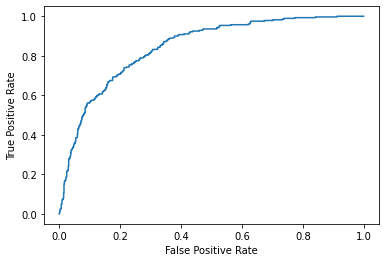

In [85]:
# Looking into ROC-AUC score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_prob = best_gridcv.predict_proba(X_val)[:, -1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

dfroc = pd.DataFrame({'False Positive Rate': fpr, 
                     'True Positive Rate': tpr,
                    'Threshold': np.round(thresholds, 2)})

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('LR Model ROC-AUC Score:', roc_auc_score(y_val, y_pred_prob))

Text(0, 0.5, 'True Positive Rate')

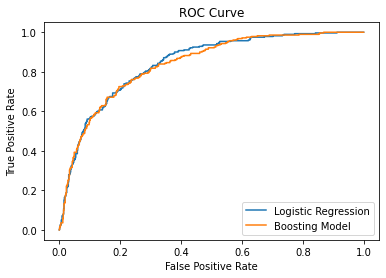

In [92]:
# Obtaining ROC
y_pred_prob_t = tree_model_best.predict_proba(X_val)[:, -1]

# Creating ROC-AUC Curve
fpr_t, tpr_t, thresholds_t = roc_curve(y_val, y_pred_prob_t)

#DF for ROC-AUC information 
dfroc_t = pd.DataFrame({'False Positive Rate': fpr, 
                     'True Positive Rate': tpr,
                    'Threshold': np.round(thresholds, 2)})


#Plotting both lines on the same graph
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot(fpr_t, tpr_t, label='Boosting Model')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [87]:
# ROC_AUC for both models
print('LR Model ROC-AUC Score:', roc_auc_score(y_val, y_pred_prob))
print('DT Model ROC-AUC Score:', roc_auc_score(y_val, y_pred_prob_t))

LR Model ROC-AUC Score: 0.8437384941089838
DT Model ROC-AUC Score: 0.8382018593519882


### PDP Plots : Islolate + Interact

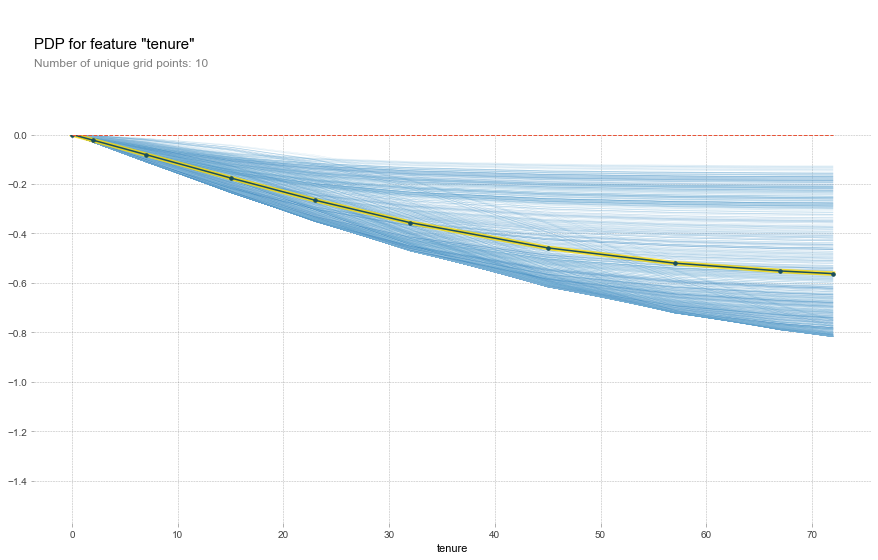

In [88]:
# PDP looking directly at Tenure and its interaction with the target Churn

from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'tenure'

isolated = pdp_isolate(
    model=best_gridcv, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature, plot_lines=True);


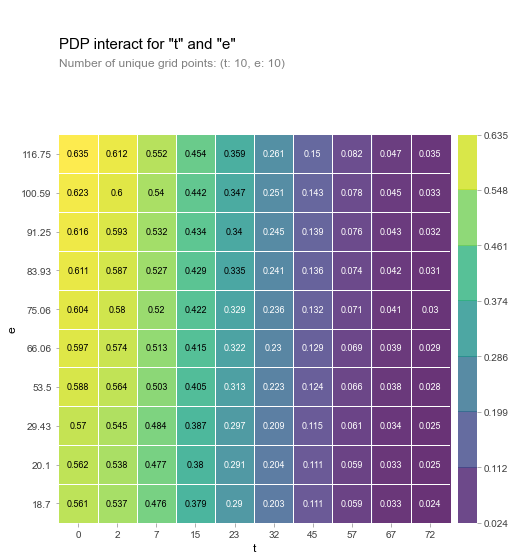

In [90]:
# PDP on Tenure and Monthly Charges 
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['tenure', 'MonthlyCharges']

interaction = pdp_interact(
    model=best_gridcv, 
    dataset=X_val, 
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=feature);